In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [5]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward -684.0, Average Max Reward: -1000.0, Total steps 684.0, Epsilon: 0.72, Alpha: 0.10, Time 0.048
Episode 100/500, Reward -540.0, Average Max Reward: -550.0, Total steps 540.0, Epsilon: 0.54, Alpha: 0.10, Time 0.040
Episode 150/500, Reward -451.0, Average Max Reward: -564.4, Total steps 451.0, Epsilon: 0.37, Alpha: 0.10, Time 0.055
Episode 200/500, Reward -285.0, Average Max Reward: -332.2, Total steps 285.0, Epsilon: 0.19, Alpha: 0.10, Time 0.021
Episode 250/500, Reward -149.0, Average Max Reward: -217.8, Total steps 149.0, Epsilon: 0.01, Alpha: 0.10, Time 0.011
Episode 300/500, Reward -170.0, Average Max Reward: -690.0, Total steps 170.0, Epsilon: 0.01, Alpha: 0.10, Time 0.020
Episode 350/500, Reward -336.0, Average Max Reward: -332.3, Total steps 336.0, Epsilon: 0.01, Alpha: 0.10, Time 0.033
Episode 400/500, Reward -197.0, Average Max Reward: -235.1, Total steps 197.0, Epsilon: 0.01, Alpha: 0.10, Time 0.014
Episode 450/500, Reward -236.0, Average Max Reward: -261

## Con-RL

In [6]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.05, 
    "e_n":0.005, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 10, 
    "max_age": 200
}

In [7]:
stats_cr= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],

}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)

Episode 50/500, Average Max Reward: -260.5, Global Error: 37.46, Total steps 111.0, Discount: 0.48, Alpha: 0.10, Time 0.088
	 MLGNG nodes per action layer: 2 1 2
Episode 100/500, Average Max Reward: -1000.0, Global Error: 14.53, Total steps 1000.0, Discount: 0.23, Alpha: 0.10, Time 1.039
	 MLGNG nodes per action layer: 10 8 10
Episode 150/500, Average Max Reward: -301.4, Global Error: 26.82, Total steps 190.0, Discount: 0.11, Alpha: 0.10, Time 0.253
	 MLGNG nodes per action layer: 10 10 10
Episode 200/500, Average Max Reward: -186.5, Global Error: 29.52, Total steps 188.0, Discount: 0.05, Alpha: 0.10, Time 0.221
	 MLGNG nodes per action layer: 10 10 8
Episode 250/500, Average Max Reward: -705.5, Global Error: 29.71, Total steps 1000.0, Discount: 0.02, Alpha: 0.10, Time 1.060
	 MLGNG nodes per action layer: 8 10 8
Episode 300/500, Average Max Reward: -1000.0, Global Error: 27.04, Total steps 1000.0, Discount: 0.01, Alpha: 0.10, Time 1.046
	 MLGNG nodes per action layer: 5 5 9
Episode 35

## Statistics

In [11]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


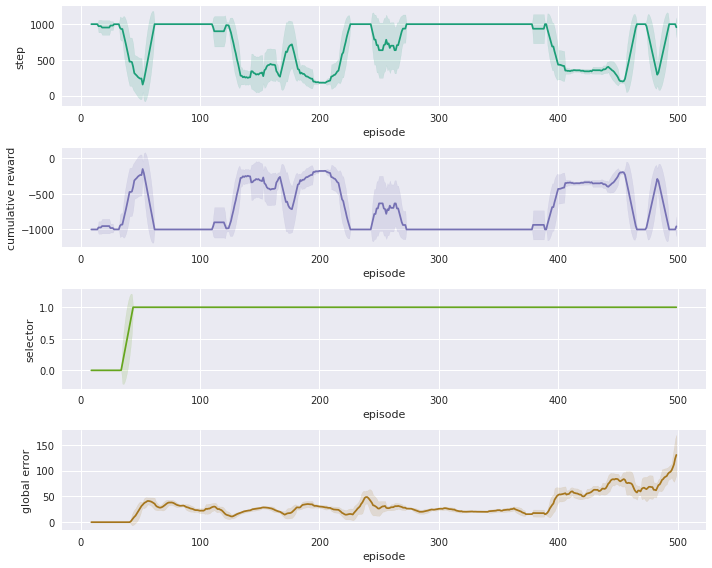

In [12]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

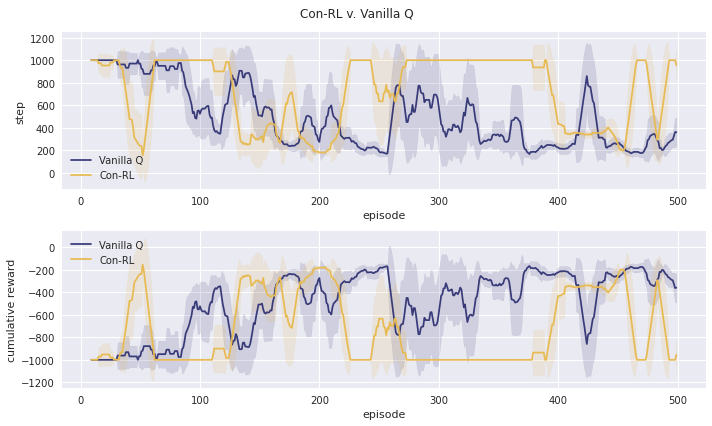

In [13]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q",
rolling_window=10)

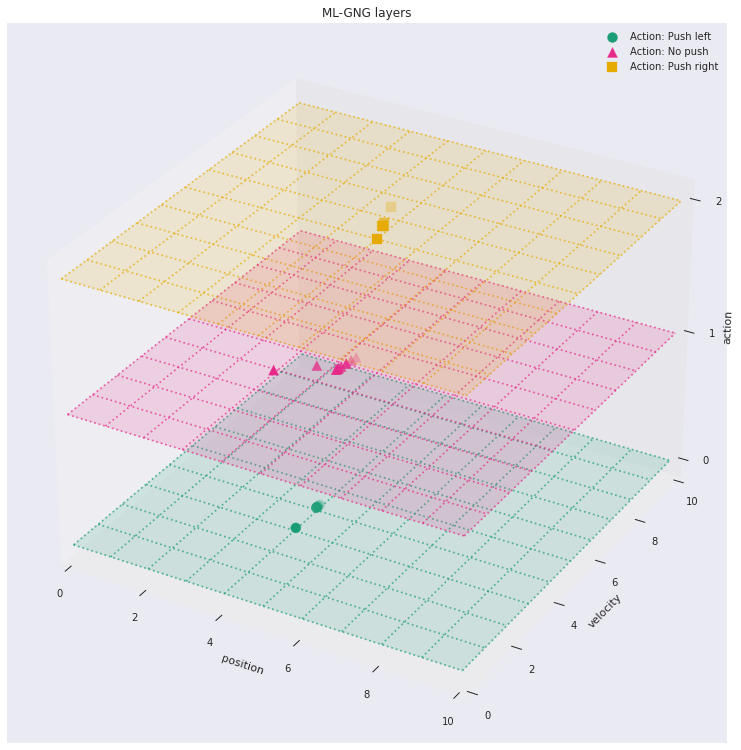

In [24]:
nodes = conrl.mlgng.get_nodes()

plot_nodes_3d(
            nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,   
            axis_names=["position", "velocity", "action"])

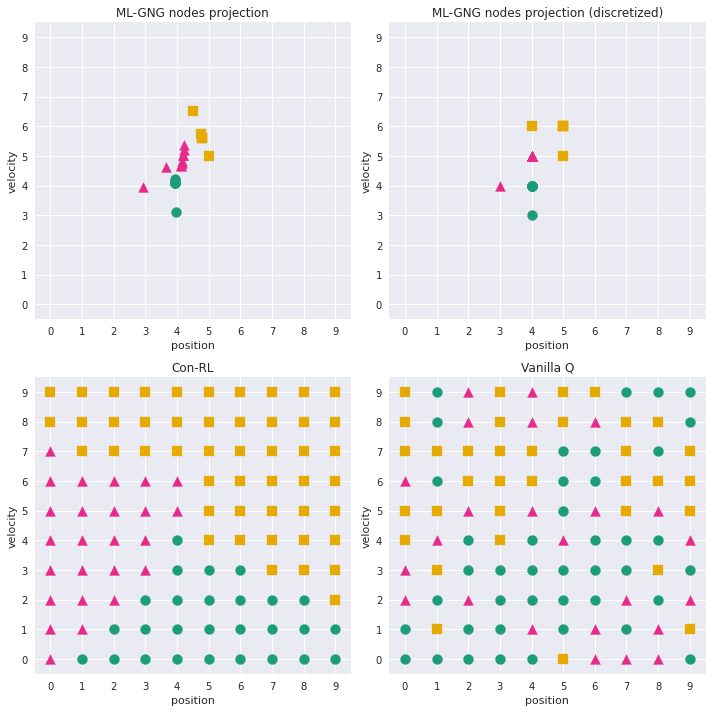

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()

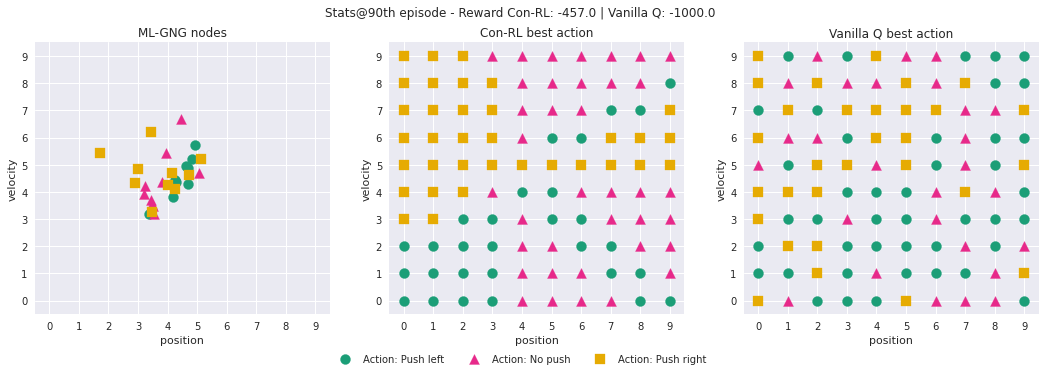

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 90
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

In [15]:
act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

In [139]:
plot_nodes_changes(stats_cr["mlgng_nodes"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr["best_actions"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)

In [28]:
plot_nodes_changes(stats_cr["mlgng_nodes"][160:170], 
                rewards=stats_cr["cumulative_reward"][160:170],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=1)

In [234]:
# Test MLGNG simplification from near optimal policy
good_policy = stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])][-1].reshape(state_size).astype(int)

stats_opt= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes)
}


for episode in range(num_episodes):
        done = False
        step = 0
        cumulative_reward = 0

        start = time.time()
        state = env.reset()

        while not done:
            action = good_policy[state]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            
            cumulative_reward += reward
            step+=1

        stats_opt["cumulative_reward"][episode] = cumulative_reward
        stats_opt["step"][episode] = step 

            
        end = time.time() - start
        if (episode+1) % 50 == 0:
            print("Episode {}/{}, Average Max Reward: {}, Total steps {}, Time {:.3f}".format(
                episode+1, 
                num_episodes, 
                stats_opt["cumulative_reward"][episode-10:episode].mean(),
                stats_opt["step"][episode],
                end))

Episode 50/500, Average Max Reward: -169.1, Total steps 155.0, Time 0.009
Episode 100/500, Average Max Reward: -157.2, Total steps 177.0, Time 0.009
Episode 150/500, Average Max Reward: -163.2, Total steps 169.0, Time 0.008
Episode 200/500, Average Max Reward: -169.1, Total steps 156.0, Time 0.007
Episode 250/500, Average Max Reward: -169.7, Total steps 177.0, Time 0.011
Episode 300/500, Average Max Reward: -157.1, Total steps 180.0, Time 0.008
Episode 350/500, Average Max Reward: -161.7, Total steps 156.0, Time 0.007
Episode 400/500, Average Max Reward: -159.0, Total steps 157.0, Time 0.007
Episode 450/500, Average Max Reward: -159.9, Total steps 155.0, Time 0.007
Episode 500/500, Average Max Reward: -149.5, Total steps 121.0, Time 0.008


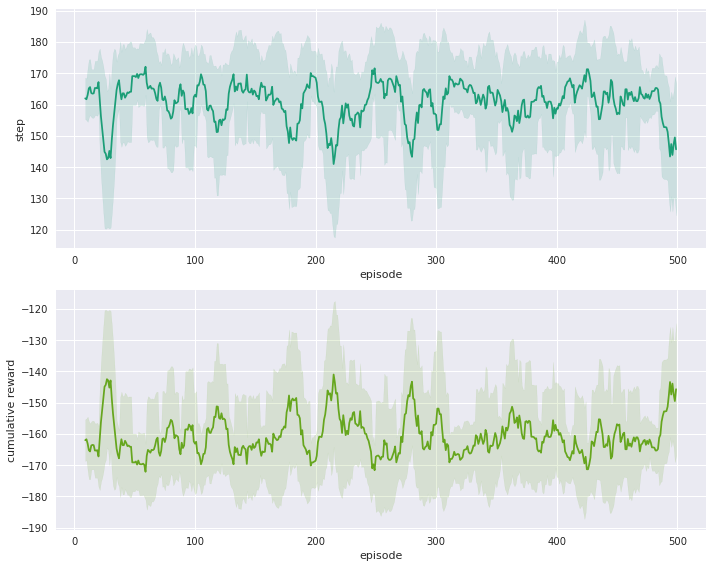

In [235]:
plot_stats(stats_opt, figsize=(10, 8))

In [236]:
class FakeSupport:
    def __init__(self, policy_table):
        self.policy_table = policy_table
        self.epsilon = 0.9
        self.epsilon_decay_rate = 0.0
        self.min_epsilon = 0.01
        self.alpha = 0.0

    def decay_param(self, param):
        decay = getattr(self, param+"_decay_rate", 0)
        value = getattr(self, param, 0)
        min_value = getattr(self, "min_"+param, 0)
        setattr(self, param, max(value-decay, min_value))

    def update(self, *args):
        pass
    
    def policy(self, state, **kwargs):
        return self.policy_table[state]
    

In [237]:
q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

stats_cr2= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],

}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = FakeSupport(good_policy)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)
conrl.train(env, num_episodes, stats_cr2)



Episode 50/500, Average Max Reward: -161.8, Global Error: 3.77, Total steps 161.0, Epsilon: 0.90, Alpha: 0.00, Time 0.249
	 MLGNG nodes per action layer: 10 10 10
Episode 100/500, Average Max Reward: -160.9, Global Error: 4.39, Total steps 124.0, Epsilon: 0.90, Alpha: 0.00, Time 0.207
	 MLGNG nodes per action layer: 10 10 10
Episode 150/500, Average Max Reward: -162.3, Global Error: 3.51, Total steps 169.0, Epsilon: 0.90, Alpha: 0.00, Time 0.198
	 MLGNG nodes per action layer: 10 10 10
Episode 200/500, Average Max Reward: -159.4, Global Error: 4.20, Total steps 177.0, Epsilon: 0.90, Alpha: 0.00, Time 0.170
	 MLGNG nodes per action layer: 10 10 10
Episode 250/500, Average Max Reward: -160.9, Global Error: 3.82, Total steps 122.0, Epsilon: 0.90, Alpha: 0.00, Time 0.140
	 MLGNG nodes per action layer: 10 10 10
Episode 300/500, Average Max Reward: -152.4, Global Error: 3.50, Total steps 121.0, Epsilon: 0.90, Alpha: 0.00, Time 0.137
	 MLGNG nodes per action layer: 10 10 10
Episode 350/500, 

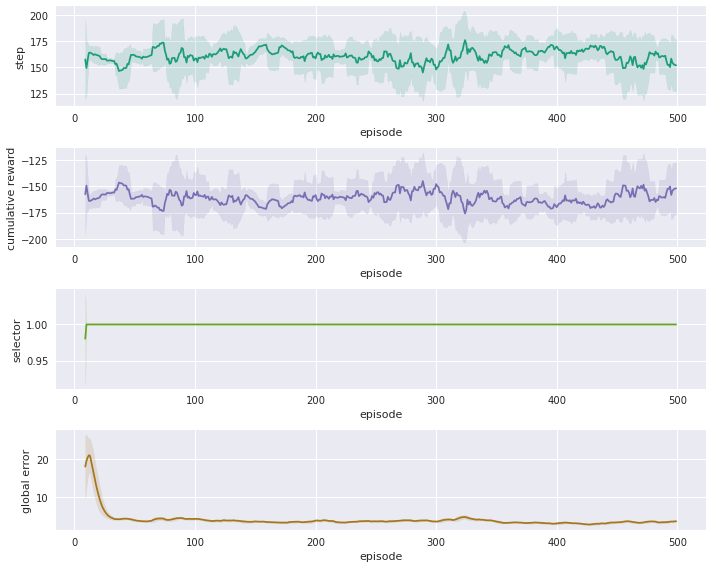

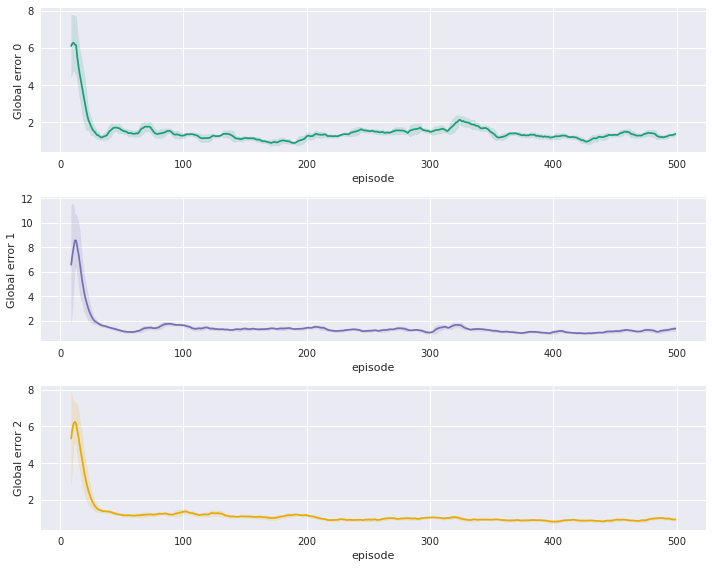

In [238]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr2.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

stats_to_plot = {"Global error {}".format(idx): stats_cr2["global_error"][:, idx] for idx in range(env.action_space.n)}
plot_stats(stats_to_plot, figsize=(10, 8))

plot_nodes_changes(stats_cr2["mlgng_nodes"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr2["best_actions"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)